In [1]:
from torch import nn
from torchsummary import summary
import torch 
# from U2Net_.model import U2NET
from scipy import ndimage
import PIL
import random

import os
import torch.nn.functional as F

import pydiffvg
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.transform import warp
from skimage import transform as tf
import imageio 
import matplotlib.font_manager as font_manager
import skimage
import skimage.io
from torchvision import transforms
import os, sys
import PIL
import time

import collections
import clip
import torch
import torch.nn as nn
from torchvision import models, transforms

p = os.path.abspath('..')
sys.path.insert(1, p)
import sketch_utils as utils
from U2Net_.model import U2NET
from scipy import ndimage
from torchvision.utils import make_grid

device = torch.device("cuda:0" if (
            torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")

In [2]:
class CLIPmaskLoss(torch.nn.Module):
    def __init__(self, clip_conv_layer_weights, mask):
        super(CLIPmaskLoss, self).__init__()
        self.clip_conv_layer_weights = clip_conv_layer_weights
        device = torch.device("cuda:0" if (
            torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")
        self.clip_model_name = "ViT-B/32"
        
        self.device = device
        self.num_augs = 4
        
        self.clip_conv_loss_type = "L2"
        self.clip_fc_loss_type = "L2"  # args.clip_fc_loss_type
        
        if mask.dim == 2:
            mask = mask.unsqueeze(0)
            self.mask = torch.cat([mask, mask, mask], axis=0).to(device)
        elif mask.dim == 3 and mask.shape[0] == 1:
            self.mask = torch.cat([mask, mask, mask], axis=0).to(device)
        else:
            self.mask = mask.to(device)
        
        self.valid_models = [
            "RN50",
            "RN101",
            "RN50x4",
            "RN50x16",
            "ViT-B/32",
            "ViT-B/16",
        ]
        assert self.clip_model_name in self.valid_models
        self.distance_metrics = \
            {
                "L2": l2_layers,
                "L1": l1_layers,
                "Cos": cos_layers
            }
        
        # background model (ViT)
        self.model, clip_preprocess = clip.load(
            self.clip_model_name, device, jit=False)
        self.model.eval()
        if self.clip_model_name.startswith("ViT"):
            self.visual_encoder = CLIPVisualEncoder(self.model)

        self.img_size = clip_preprocess.transforms[1].size
        
        self.target_transform = transforms.Compose([
            transforms.ToTensor(),
        ])  # clip normalisation
        self.normalize_transform = transforms.Compose([
            # clip_preprocess.transforms[0],  # Resize
            # clip_preprocess.transforms[1],  # CenterCrop
            clip_preprocess.transforms[-1],  # Normalize
        ])        
        
        augemntations = []
        augemntations.append(transforms.RandomPerspective(
            fill=0, p=1.0, distortion_scale=0.5))
        augemntations.append(transforms.RandomResizedCrop(
            224, scale=(0.4, 0.9), ratio=(1.0, 1.0)))
        
        self.augment_trans = transforms.Compose(augemntations)
        self.clip_fc_layer_dims = None  # self.args.clip_fc_layer_dims
        self.clip_conv_layer_dims = None  # self.args.clip_conv_layer_dims
        self.clip_fc_loss_weight = 0
        self.counter = 0

    def forward(self, sketch, target, mode="train"):
        """
        Parameters
        ----------
        sketch: Torch Tensor [1, C, H, W]
        target: Torch Tensor [1, C, H, W]
        """
        conv_loss_dict = {}
        
        x = sketch.to(self.device)
        y = target.to(self.device)
        sketch_augs, img_augs, masks = [x], [y], [self.mask]
        if mode == "train":
            for n in range(self.num_augs):
                augmented_pair = self.augment_trans(torch.cat([x, y, self.mask]))
                sketch_augs.append(augmented_pair[0].unsqueeze(0))
                img_augs.append(augmented_pair[1].unsqueeze(0))
                masks.append(augmented_pair[2].unsqueeze(0))
        xs = torch.cat(sketch_augs, dim=0).to(self.device)
        ys = torch.cat(img_augs, dim=0).to(self.device)
        masks = torch.cat(masks, dim=0).to(self.device)
        masks[masks < 0.5] = 0
        masks[masks >= 0.5] = 1
        
        # background pass
        xs_back = self.normalize_transform(xs)
        ys_back = self.normalize_transform(ys)
        xs_fc_features, xs_conv_features = self.visual_encoder(xs_back, None)
        ys_fc_features, ys_conv_features = self.visual_encoder(ys_back, None)
        conv_loss = self.distance_metrics[self.clip_conv_loss_type](
            xs_conv_features, ys_conv_features, self.clip_model_name)
        for layer, w in enumerate(self.clip_conv_layer_weights):
            if w:
                conv_loss_dict[f"clip_conv_loss_layer{layer}"] = conv_loss[layer] * w
        if self.clip_fc_loss_weight:
            # fc distance is always cos
            fc_loss = (1 - torch.cosine_similarity(xs_fc_features,
                       ys_fc_features, dim=1)).mean()
            conv_loss_dict[f"fc"] = fc_loss * self.clip_fc_loss_weight
        self.counter += 1
        return conv_loss_dict

    def forward_inspection_clip_resnet(self, x):
        def stem(m, x):
            for conv, bn in [(m.conv1, m.bn1), (m.conv2, m.bn2), (m.conv3, m.bn3)]:
                x = m.relu(bn(conv(x)))
            x = m.avgpool(x)
            return x
        x = x.type(self.visual_model.conv1.weight.dtype)
        x = stem(self.visual_model, x)
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        y = self.att_pool2d(x4)
        return y, [x, x1, x2, x3, x4]


def l2_layers(xs_conv_features, ys_conv_features, clip_model_name):
    return [torch.square(x_conv - y_conv).mean() for x_conv, y_conv in
            zip(xs_conv_features, ys_conv_features)]


def l1_layers(xs_conv_features, ys_conv_features, clip_model_name):
    return [torch.abs(x_conv - y_conv).mean() for x_conv, y_conv in
            zip(xs_conv_features, ys_conv_features)]


def cos_layers(xs_conv_features, ys_conv_features, clip_model_name):
    if "RN" in clip_model_name:
        return [torch.square(x_conv, y_conv, dim=1).mean() for x_conv, y_conv in
                zip(xs_conv_features, ys_conv_features)]
    return [(1 - torch.cosine_similarity(x_conv, y_conv, dim=-1)).mean() for x_conv, y_conv in
            zip(xs_conv_features, ys_conv_features)]


class CLIPVisualEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        # print(clip_model)
        self.clip_model = clip_model
        self.featuremaps = None
        self.mask_latent = False
        self.apply_mask = False
        self.mask_only_cls = False
        self.vit_keys = None
        self.keys_loss = False
        self.hook_handlers = []
    
    def _register_hooks(self):
        for i in range(12):  # 12 resblocks in VIT visual transformer
            self.hook_handlers.append(self.clip_model.visual.transformer.resblocks[i].register_forward_hook(
                self.make_hook(i)))
    
    def _register_hooks_keys(self):
        for i in range(12):  # 12 resblocks in VIT visual transformer
            self.hook_handlers.append(self.clip_model.visual.transformer.resblocks[i].attn.attn_keys.register_forward_hook(
                self.make_hook(i)))
    
    
    def _clear_hooks(self):
        for handler in self.hook_handlers:
            handler.remove()
        self.hook_handlers = []
    
    def make_hook(self, name):
        def hook(module, input, output):
            # print("=== hook ====")
            # print(name, input[0].shape, input[0].shape, output.shape)
            if len(output.shape) == 3:
                self.featuremaps[name] = output.permute(
                    1, 0, 2)  # LND -> NLD bs, smth, 768
            else:
                self.featuremaps[name] = output
        return hook

    def forward(self, x, masks=None):
        masks_flat = torch.ones((x.shape[0], 50, 768)).to(device)
        attn_map = None
        if self.apply_mask and masks is not None:
            x_copy = x.detach().clone()
            n_channels, kernel_h, kernel_w, step = 3, 32, 32, 32
            num_patches = 49
            patches_x = x_copy.unfold(2, kernel_h, step).unfold(3, kernel_w, step).reshape(-1, n_channels, num_patches, 32, 32) 
            # shape is (batch_size, channel, num_patches, patch_size, patch_size) = (5, 3, 49, 32, 32)
            patches_mask = masks.unfold(2, kernel_h, step).unfold(3, kernel_w, step).reshape(-1, n_channels, num_patches, 32, 32) 

            masks_ = torch.ones((x.shape[0],1,7,7)).cuda()
            for i in range(masks.shape[0]):
                for j in range(num_patches):
                    zeros = (patches_mask[i, 0, j] == 0).sum() / (kernel_w * kernel_h)
                    # print(zeros)
                    if zeros > 0.2:
                        masks_[i, :, j // 7, j % 7] = 0

            mask2 = masks_[:,0].reshape(-1, 49).to(device) # shape (5, 49)
            mask2 = torch.cat([torch.ones(mask2.shape[0],1).to(device), mask2], dim=-1)
            mask2 = mask2.unsqueeze(1) # [5, 1, 50]
            attn_map = mask2.repeat(1,50,1).to(device) # 5, 50, 50
            attn_map[:,0,0] = 1
            attn_map = 1 - attn_map
            indixes = (attn_map == 0).nonzero() # shape [136, 2] [[aug_im],[index]]
            attn_map = attn_map.repeat(12,1,1).bool() # [60, 50, 50]

            if self.mask_latent:
                masks_flat = masks_[:,0].reshape(-1, 49)#.to(device) shape (5, 49)
                indixes = (masks_flat == 0).nonzero() # shape [136, 2] [[aug_im],[index]]
                for t in indixes:
                    b_num, y, x_ = t[0], t[1] // 7, t[1] % 7
                    x_copy[b_num, :, 32 * y: 32 * y + 32, 32 * x_: 32 * x_ + 32] = 0
                masks_flat = torch.cat([torch.ones(masks_flat.shape[0],1).to(device), masks_flat], dim=1)
                masks_flat = masks_flat.unsqueeze(2).repeat(1, 1, 768)
            if self.mask_only_cls:
                masks_flat = torch.ones((5, 50, 768)).to(device)
                masks_flat[:, 0, :] = 0
        
        self.featuremaps = collections.OrderedDict()
        self._register_hooks()
        fc_features = self.clip_model.encode_image(x).float() # this line fills self.featuremaps 
        featuremaps = [self.featuremaps[k] * masks_flat for k in range(12)]
        self._clear_hooks()
        return fc_features, featuremaps

In [3]:
def get_initial_points(path_svg, target_="", device=None):
    canvas_width, canvas_height, shapes, shape_groups = pydiffvg.svg_to_scene(
        path_svg)
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,   # num_samples_x
                 2,   # num_samples_y
                 0,   # seed
                 None,
                 *scene_args)

    points_vars = []
    for i, path in enumerate(shapes):
        points_vars.append(path.points)
    
    # plt.imshow(img.cpu().numpy())
    # plt.show()
    return points_vars

def get_path(inds_normalised, strokes_counter, device, num_segments=1, control_points_per_seg=4, canvas_width=224, canvas_height=224):
    points = []
    num_control_points = torch.zeros(num_segments, dtype = torch.int32) + (control_points_per_seg - 2)
    p0 = inds_normalised[strokes_counter]
    points.append(p0)

    for j in range(num_segments):
        radius = 0.05
        for k in range(control_points_per_seg - 1):
            p1 = (p0[0] + radius * (random.random() - 0.5), p0[1] + radius * (random.random() - 0.5))
            points.append(p1)
            p0 = p1
    points = torch.tensor(points).to(device)
    points[:, 0] *= canvas_width
    points[:, 1] *= canvas_height

    path = pydiffvg.Path(num_control_points = num_control_points,
                            points = points,
                            stroke_width = torch.tensor(1.5),
                            is_closed = False)
    return path



def render_points(points, widths, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224):
    all_points = 0.5 * (points + 1.0) * canvas_size
    # print("all_points", all_points)
    eps = 1e-4
    all_points = all_points + eps*torch.randn_like(all_points)
    all_points = all_points.reshape((-1, num_strokes, num_cp, 2))
    num_control_points = torch.zeros(1, dtype = torch.int32) + (4 - 2)

    shapes = []
    shape_groups = []
    for p in range(num_strokes):
        width = torch.tensor(1.0)
        if widths is not None:
            width = widths[p]
        path = pydiffvg.Path(
            num_control_points=num_control_points, points=all_points[:,p].reshape((-1,2)),
            stroke_width=width, is_closed=False)
        shapes.append(path)
        path_group = pydiffvg.ShapeGroup(
            shape_ids=torch.tensor([len(shapes) - 1]),
            fill_color=None,
            stroke_color=torch.tensor([0,0,0,1]))
        shape_groups.append(path_group)

    # Rasterize
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,   # num_samples_x
                 2,   # num_samples_y
                 0,   # seed
                 None,
                 *scene_args)
    img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = pydiffvg.get_device()) * (1 - img[:, :, 3:4])
        
    # plt.imshow(img.detach().cpu().numpy())
    # plt.show()
    return img
    

def get_target(target_, device, image_scale=224):
    target = Image.open(target_)
    if target.mode == "RGBA":
        # Create a white rgba background
        new_image = Image.new("RGBA", target.size, "WHITE")
        # Paste the image on the background.
        new_image.paste(target, (0, 0), target)
        target = new_image
    target = target.convert("RGB")

    transforms_ = []
    if target.size[0] != target.size[1]:
        transforms_.append(transforms.Resize(
            (image_scale, image_scale), interpolation=PIL.Image.BICUBIC))
    else:
        transforms_.append(transforms.Resize(
            image_scale, interpolation=PIL.Image.BICUBIC))
        transforms_.append(transforms.CenterCrop(image_scale))
    transforms_.append(transforms.ToTensor())
    data_transforms = transforms.Compose(transforms_)
    target_ = data_transforms(target).unsqueeze(0).to(device)
    # masked_im, mask = get_mask_u2net(target_, device, use_gpu=True)
    return target_, torch.ones((224,224))#mask
    
def get_mask_u2net(tensor_im, device, use_gpu=True):
    data_transforms = transforms.Compose([
        # transforms.ToTensor(),
        transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(
            0.26862954, 0.26130258, 0.27577711)),
    ])

    input_im_trans = data_transforms(tensor_im).to(device)

    model_dir = os.path.join("/home/vinker/dev/backgroundCLIPasso/CLIPasso/U2Net_/saved_models/u2net.pth")
    net = U2NET(3, 1)
    if torch.cuda.is_available() and use_gpu:
        net.load_state_dict(torch.load(model_dir, map_location=torch.device("cuda:2")))
        net.to(device)
    else:
        net.load_state_dict(torch.load(model_dir, map_location='cpu'))
    net.eval()
    with torch.no_grad():
        d1, d2, d3, d4, d5, d6, d7 = net(input_im_trans.detach())
    pred = d1[:, 0, :, :]
    pred = (pred - pred.min()) / (pred.max() - pred.min())
    predict = pred
    predict[predict < 0.5] = 0
    predict[predict >= 0.5] = 1
    
    # print(predict[0].shape, ndimage.generate_binary_structure(5, 5).shape)
    predict = 1 - torch.tensor(ndimage.binary_dilation(predict[0].cpu().numpy(), structure=np.ones((11,11))).astype(np.int)).unsqueeze(0).to(device)
    mask = torch.cat([predict, predict, predict], axis=0).permute(1, 2, 0)
    mask = mask.cpu().numpy()
    
    # print(mask.max(), mask.dtype)
    # predict_np = predict.clone().cpu().data.numpy()
    im = Image.fromarray((mask[:, :, 0]*255).astype(np.uint8)).convert('RGB')
    # im.save(f"{args.output_dir}/mask.png")

    im_np = tensor_im[0].permute(1,2,0).cpu().numpy()
    im_np = im_np / im_np.max()
    im_np = mask * im_np
    im_np[mask == 0] = 1
    im_final = (im_np / im_np.max() * 255).astype(np.uint8)
    im_final = Image.fromarray(im_final)

    return im_final, predict



def get_initial_points_mask(mask, num_strokes, device, canvas_width=224, canvas_height=224):
    # print(mask.shape)
    mask = mask[0].cpu().numpy().astype(float)
    mask[mask > 0] = mask[mask > 0] / mask.sum()
    mask_prob = mask.astype(float) 
    # mask_prob = 
    # print(mask_prob.sum())
    k = num_strokes
    inds = np.random.choice(range(mask_prob.flatten().shape[0]), size=k, replace=False, p=mask_prob.flatten())
    inds = np.array(np.unravel_index(inds, mask_prob.shape)).T
    # print(inds)
    inds_normalised = np.zeros(inds.shape)
    inds_normalised[:, 0] =  inds[:, 1] / canvas_width
    inds_normalised[:, 1] =  inds[:, 0] / canvas_height
    inds_normalised = inds_normalised.tolist()
    # print(inds_normalised)
    shape_groups, shapes = [], []
    for i in range(num_strokes):
        # print(i)
        stroke_color = torch.tensor([0.0, 0.0, 0.0, 1.0])
        path = get_path(inds_normalised, i, device)
        shapes.append(path)
        path_group = pydiffvg.ShapeGroup(shape_ids = torch.tensor([len(shapes) - 1]),
                                            fill_color = None,
                                            stroke_color = stroke_color)
        shape_groups.append(path_group)
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,   # num_samples_x
                 2,   # num_samples_y
                 0,   # seed
                 None,
                 *scene_args)

    points_vars = []
    for i, path in enumerate(shapes):
        points_vars.append(path.points)
    
    # plt.imshow(img.cpu().numpy())
    # plt.show()
    return points_vars

def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape).to(device)
    # if is_cuda:
    #     U = U.cuda()
    return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature, hard=False, latent_dim=5, categorical_dim=2):
    """
    ST-gumple-softmax
    input: [*, n_class]
    return: flatten --> [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    
    if not hard:
        return y.view(-1, latent_dim * categorical_dim)

    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    # Set gradients w.r.t. y_hard gradients w.r.t. y
    y_hard = (y_hard - y).detach() + y
    return y_hard.view(latent_dim, categorical_dim)

def get_svg_file(path):
    files = os.listdir(path)
    files = [f for f in files if ".svg" in f]
    return files[0]  


In [4]:
class MLP(nn.Module):
    def __init__(self, num_strokes, num_cp):
        super().__init__()
        outdim = 1000
        # num_strokes = 32
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_strokes * num_cp * 2, outdim),
            nn.SELU(inplace=True),
            nn.Linear(outdim, outdim),
            nn.SELU(inplace=True),
            # nn.ReLU(),
            # nn.Linear(1000, 1000),
            # nn.ReLU(),
            nn.Linear(outdim, num_strokes * num_cp * 2),
            # nn.Tanh()
        )
        
        # self.layers_width = nn.Sequential(
        #     nn.Linear(num_strokes, num_strokes),
        #     nn.SELU(inplace=True),
        #     nn.Linear(num_strokes, num_strokes),
        #     nn.SELU(inplace=True),
        #     nn.Linear(num_strokes, num_strokes),
        #     nn.Sigmoid()
        # )


    def forward(self, x, widths=None):
        '''Forward pass'''
        deltas = self.layers(x)
        # print(deltas.shape)
        # print(x.flatten().shape)
        # if widths is not None:
        #     return x.flatten() + 0.1 * deltas, self.layers_width(widths)
        return x.flatten() + 0.1 * deltas

class MLPWidth(nn.Module):
    def __init__(self, num_strokes, num_cp):
        super().__init__()
        self.num_strokes = num_strokes
        # self.weights = torch.nn.Parameter(torch.ones(2).float())
        outdim = 1000
        # num_strokes = 32        
        self.layers_width = nn.Sequential(
            nn.Linear(num_strokes, outdim),
            nn.SELU(inplace=True),
            nn.Linear(outdim, outdim),
            nn.SELU(inplace=True),
            nn.Linear(outdim, num_strokes),
            nn.Sigmoid()
        )


    def forward(self, widths=None):
        '''Forward pass'''
        res = self.layers_width(widths)#.view(self.num_strokes, 2)
        # print(res.shape)
        return res
        

In [5]:
def optimize_through_net(target, points_vars, mlp, mlp_opt, mlp_width, optimizer_width, loss_clip, device, width_weight=0.0, canvas_size=224, num_strokes=32, num_cp=4, only_width=False, num_iter=10, print_int=10):
    # widths = torch.ones((num_strokes)).to(device)
    # widths = torch.rand((num_strokes)).to(device)
    init_width = torch.ones((num_strokes)).to(device) * 1.5
    # widths = 2*widths-1
    widths = init_width

    # widths = torch.zeros((num_strokes)).to(device)
    losses_clip = []
    losses_width = []
    lowest_loss = 100
    best_iter = 0
    best_im = None
    best_num_strokes = num_strokes
    zero = torch.tensor(0).to(device)
    # widths = torch.rand((num_strokes)).to(device)
    for t in range(num_iter):
        if not only_width:
            mlp_opt.zero_grad()
        optimizer_width.zero_grad()
        
        if widths is not None:
            widths_ = mlp_width(widths)
            mask_flipped = 1 - widths_
            v = torch.stack((torch.log(widths_), torch.log(mask_flipped)), dim=-1)
            hard_mask = torch.nn.functional.gumbel_softmax(v, 0.2, False)
            new_mask = hard_mask[:, 0] * init_width
            # print(hard_mask[:, 0].shape)
        # new_mask = widths
        # with torch.no_grad():
        #     points = mlp(points_vars, None)
        if not only_width:
            points = mlp(points_vars, None)
            # print(points[0])
        else:
            points = points_vars
        img_ = render_points(points, new_mask, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224)  
        # plt.imshow(img_.cpu().detach().numpy())
        # plt.show()
        # plt.close()
        img = img_[:, :, :3]
        # Convert img from HWC to NCHW
        img = img.unsqueeze(0)
        img = img.permute(0, 3, 1, 2) # NHWC -> NCHW
        
        # sketch, target
        loss_clip_ = loss_clip(img, target, mode="train")      

        sum_w = torch.sum(hard_mask[:, 0])
        # mini_loss = width_weight * sum_w  # minimal sum
        
        mini_loss = torch.max(zero, sum_w - width_weight)
        # k_loss = 0 * (torch.sum(hard_mask[:, 0]) - k) ** 2  # choose only k values
        
        loss_clip_sum = sum(list(loss_clip_.values()))
        
        loss =  loss_clip_sum +  mini_loss
        losses_clip.append(loss_clip_sum.item())
        losses_width.append(mini_loss.item())
        
        loss.backward()
        if not only_width:
            mlp_opt.step()
        optimizer_width.step()
        
        if loss.item() <= lowest_loss:
            best_im = img_
            lowest_loss = loss.item()
            best_iter = t
            best_num_strokes = sum_w.item()
    # plt.show()
    # plt.close()
    points = mlp(points_vars)
    img = render_points(points, new_mask, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224)
    return img, best_im, losses_clip, losses_width, best_iter, best_num_strokes

Cos_mlp_ViT_l4_32s_semi-complex_mask_seed0


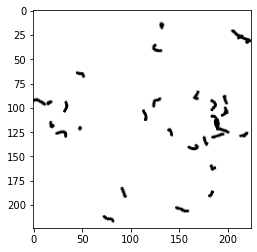

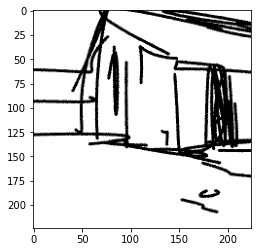

4
time: 69.85169625282288


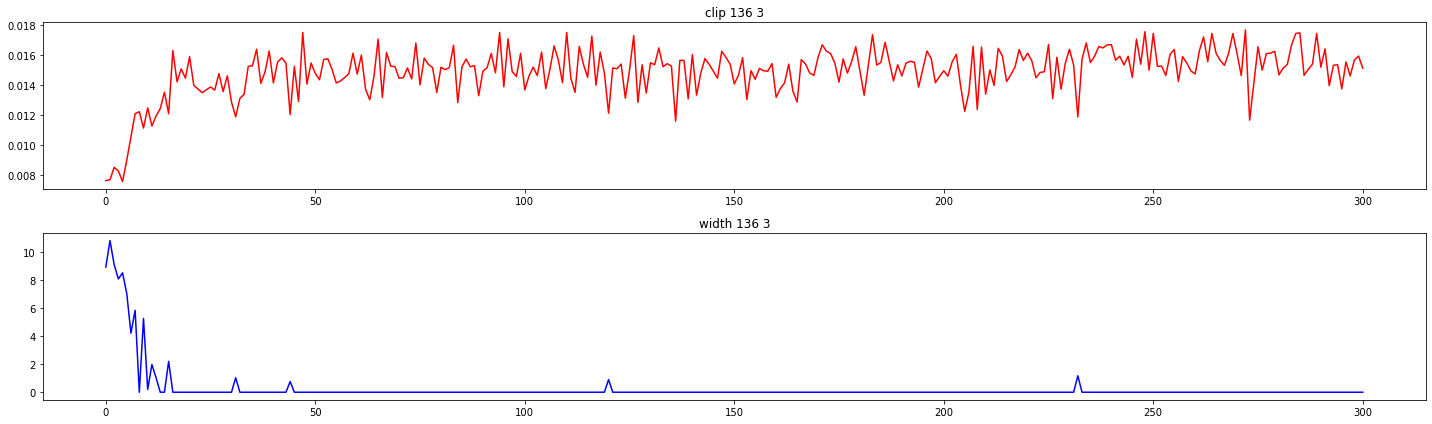

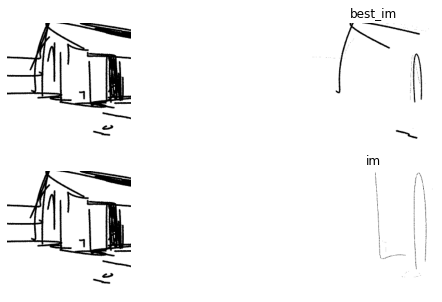

In [23]:
# tests

# random.seed(0)
# np.random.seed(0)
# # os.environ['PYTHONHASHSEED'] = str(seed)
# torch.manual_seed(0)



im_name = "semi-complex_mask"
# im_name = "complex-scene-crop_mask"

# layers = [3,4,5,6,7,8,9,10,11]
layers = [4]
weights = np.array([31, 16, 8, 4]) 
weights = np.array([4]) 


# weights = np.array([0.0001, 0.0004, 0.0008, 0.001]) 
canvas_size=224
num_strokes=32
num_cp=4

num_iter=301
# target_ = "/home/vinker/dev/background_project/notebooks/complex_level_scenes/semi-complex_mask.png"
all_arr = []
for layer in layers:
    # im_name = "complex-scene-crop_mask"
    path_res = f"/home/vinker/dev/background_project/experiements/mlp_19_06/Cos_mlp_ViT_l{layer}_32s_{im_name}/"#best_mask1_semi-complex_ViT_l4_32s_seed0/svg_logs/svg_iter1000.svg"
    svg_filename = get_svg_file(path_res)
    path_svg = f"{path_res}/{svg_filename}"
    best_svg_folder = svg_filename[:-9]
    print(best_svg_folder)
    mlp_path = f"{path_res}/{best_svg_folder}/mlp.pth"
    svg_init_path = f"{path_res}/{best_svg_folder}/svg_logs/svg_iter0.svg"

    points_vars = get_initial_points(svg_init_path, device=device) # list of tensors
    points_vars = torch.stack(points_vars).unsqueeze(0).to(device)
    points_vars = points_vars / canvas_size
    points_vars = 2*points_vars-1
    

    widths = torch.ones(num_strokes) * 1.5
    # im1 = render_points(points_vars, widths, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224)

#     imageio.imsave(f"house_layer{layer}.png", im1.detach().cpu().numpy())
    target_ = f"images/house_layer{layer}.png"
    target, mask = get_target(target_, device, image_scale=224)
    
    clip_conv_layer_weights=[0,0,0,0,0,0,0,0,0,0,0,0]
    clip_conv_layer_weights[4] = 1
    loss_clip = CLIPmaskLoss(clip_conv_layer_weights, mask)
    
    mlp = MLP(num_strokes=num_strokes, num_cp=num_cp).to(device)
    
    checkpoint = torch.load(mlp_path)
    # start_epoch = checkpoint['epoch']
    mlp.load_state_dict(checkpoint)
    with torch.no_grad():
        points_vars = mlp(points_vars, None)
    
    
    # points = mlp(points_vars, None)
    img_ = render_points(points_vars, widths, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224)
    plt.imshow(img_.cpu().detach().numpy())
    plt.show()
    
    mlp_width = MLPWidth(num_strokes=num_strokes, num_cp=num_cp).to(device)
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    # mlp_width.apply(init_weights)
    optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
    optimizer_width = torch.optim.Adam(mlp_width.parameters(), lr=1e-4)

    results = []
    results_f = []
    plt.figure(figsize=(20,6))
    for i, w in enumerate(weights):
        print(w)
        start = time.time()
        im, best_im, losses_clip, losses_width, best_iter, best_num_strokes = optimize_through_net(target, points_vars, mlp, optimizer, mlp_width, optimizer_width, loss_clip, device, width_weight=w, canvas_size=224, num_strokes=num_strokes, num_cp=4, only_width=True, num_iter=num_iter, print_int=100)
        
        plt.subplot(2,len(weights),i + 1)
        plt.plot(range(num_iter), losses_clip, color='r')
        plt.title(f"clip {best_iter} {int(best_num_strokes)}")
        
        plt.subplot(2,len(weights),len(weights) + i + 1)
        plt.plot(range(num_iter), losses_width, color='b')
        plt.title(f"width {best_iter} {int(best_num_strokes)}")
        results.append(best_im)
        results_f.append(im)
        
        
        print("time:", time.time() - start)
        del mlp
    plt.tight_layout()
    plt.show()
    plt.close()
    all_arr.append(results)

    # plt.figure(figsize=(20,10))
    plt.figure(figsize=(10,5))
    plt.subplot(2,len(results) + 1,1)
    plt.imshow(target[0].permute(1,2,0).detach().cpu().numpy())
    plt.axis("off")
    plt.subplot(2,len(results) + 1,len(results) + 2)
    plt.imshow(target[0].permute(1,2,0).detach().cpu().numpy())
    plt.axis("off")
    for i, res in enumerate(results):
        plt.subplot(2,len(results) + 1,i + 2)
        plt.imshow(res.detach().cpu().numpy())
        plt.axis("off")
        plt.title("best_im")
        plt.subplot(2,len(results) + 1,len(results) + i + 3)
        plt.imshow(results_f[i].detach().cpu().numpy())
        plt.axis("off")
        plt.title("im")
    plt.show()
    plt.close()

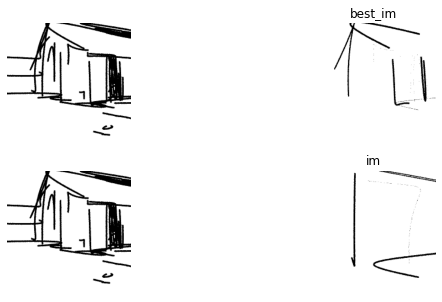

In [16]:
plt.figure(figsize=(10,5))
plt.subplot(2,len(results) + 1,1)
plt.imshow(target[0].permute(1,2,0).detach().cpu().numpy())
plt.axis("off")
plt.subplot(2,len(results) + 1,len(results) + 2)
plt.imshow(target[0].permute(1,2,0).detach().cpu().numpy())
plt.axis("off")
for i, res in enumerate(results):
    plt.subplot(2,len(results) + 1,i + 2)
    plt.imshow(res.detach().cpu().numpy())
    plt.axis("off")
    plt.title("best_im")
    plt.subplot(2,len(results) + 1,len(results) + i + 3)
    plt.imshow(results_f[i].detach().cpu().numpy())
    plt.axis("off")
    plt.title("im")
plt.show()
plt.close()

In [5]:
class WeightMethods:

    def __init__(self, method: str, **kwargs):
        """
        :param method:
        """
        baselines = dict(
            gradnorm=GradNorm,

        )
        assert method in list(baselines.keys()), 'unknown weight method'

        self.method = baselines[method](**kwargs)

    def backwards(self, losses, **kwargs):
        return self.method.backward(losses, **kwargs)

class WeightingMethod:

    # @abstractmethod
    def backward(self, losses, *args, **kwargs):
        pass

class GradNorm(WeightingMethod):
    """Implementation of 'GradNorm: Gradient Normalization for Adaptive Loss Balancing in Deep Multitask Networks'.
    Minor modifications of https://github.com/choltz95/MTGP-NN/blob/master/models.py#L80-L112. See also
    https://github.com/hosseinshn/GradNorm/blob/master/GradNormv10.ipynb
    """
    def __init__(self, n_tasks=2, alpha=1.5, device=None, **kwargs):
        """
        :param n_tasks:
        :param alpha: the default 1.5 is the same as in the paper for NYU experiments
        """
        self.n_tasks = n_tasks
        self.alpha = alpha
        self.weights = torch.ones((n_tasks, ), requires_grad=True, device=device)
        self.init_losses = None

    def backward(self, losses, last_shared_params, returns=True, **kwargs):
        """Update gradients of the weights.
        :param losses:
        :param last_shared_params:
        :param returns:
        :return:
        """
        print("self.weights", self.weights)
        if isinstance(losses, list):
            losses = torch.stack(losses)

        if self.init_losses is None:
            self.init_losses = losses.detach().data

        weighted_losses = self.weights * losses
        print("weighted_losses", weighted_losses)
        total_weighted_loss = weighted_losses.sum()
        # compute and retain gradients
        total_weighted_loss.backward(retain_graph=True)
        # zero the w_i(t) gradients since we want to update the weights using gradnorm loss
        self.weights.grad = 0.0 * self.weights.grad

        # compute grad norms
        norms = []
        for w_i, L_i in zip(self.weights, losses):
            dlidW = torch.autograd.grad(L_i, last_shared_params, retain_graph=True)[0]
            norms.append(torch.norm(w_i * dlidW))

        norms = torch.stack(norms)

        # compute the constant term without accumulating gradients
        # as it should stay constant during back-propagation
        with torch.no_grad():
            # loss ratios
            loss_ratios = losses / self.init_losses
            # inverse training rate r(t)
            inverse_train_rates = loss_ratios / loss_ratios.mean()
            constant_term = norms.mean() * (inverse_train_rates ** self.alpha)

        grad_norm_loss = (norms - constant_term).abs().sum()
        self.weights.grad = torch.autograd.grad(grad_norm_loss, self.weights)[0]

        # make sure sum_i w_i = T, where T is the number of tasks
        with torch.no_grad():
            renormalize_coeff = self.n_tasks / self.weights.sum()
            self.weights *= renormalize_coeff

        if returns:
            return total_weighted_loss, weighted_losses

In [20]:
def width_step(optimizer_width, init_width, points_vars, train_mlp, canvas_size, num_strokes, mlp, mlp_width, width_loss, width_weight, zero):
    optimizer_width.zero_grad()
    widths_ = mlp_width(init_width)
    mask_flipped = 1 - widths_
    v = torch.stack((torch.log(widths_), torch.log(mask_flipped)), dim=-1)
    hard_mask = torch.nn.functional.gumbel_softmax(v, 0.2, False)
    widths = hard_mask[:, 0] * init_width
    if "points" in train_mlp:
        with torch.no_grad():
            points = mlp(points_vars, None)
    else:
        points = points_vars
    img_ = render_points(points, widths, canvas_size, num_strokes, num_cp=4, canvas_width=224, canvas_height=224)
    # print(hard_mask[:, 0].shape)
    sum_w = torch.sum(hard_mask[:, 0]) 
    if width_loss == "l1":
        mini_loss = sum_w / hard_mask[:, 0].shape[0]
    else:
        mini_loss = torch.max(zero, sum_w - width_weight)
    return img_, mini_loss, widths, sum_w

def points_step(mlp_opt, widths, points_vars, canvas_size, num_strokes, mlp):
    mlp_opt.zero_grad()        
    points = mlp(points_vars, None)
    img_ = render_points(points, widths.detach(), canvas_size, num_strokes, num_cp=4, canvas_width=224, canvas_height=224) 
    return img_

def width_and_points_step(optimizer_width, init_width, points_vars, train_mlp, canvas_size, num_strokes, mlp, mlp_width, width_loss, width_weight, zero, mlp_opt):
    mlp_opt.zero_grad()
    optimizer_width.zero_grad()
    points = mlp(points_vars, None)
    widths_ = mlp_width(init_width)
    mask_flipped = 1 - widths_
    v = torch.stack((torch.log(widths_), torch.log(mask_flipped)), dim=-1)
    hard_mask = torch.nn.functional.gumbel_softmax(v, 0.2, False)
    widths = hard_mask[:, 0] * init_width
    img_ = render_points(points, widths, canvas_size, num_strokes, num_cp=4, canvas_width=224, canvas_height=224)
    # print(hard_mask[:, 0].shape)
    sum_w = torch.sum(hard_mask[:, 0]) 
    if width_loss == "l1":
        mini_loss = sum_w / hard_mask[:, 0].shape[0]
    else:
        mini_loss = torch.max(zero, sum_w - width_weight)
    return img_, mini_loss, widths, sum_w


def compute_grad_norm_losses(losses, model):
    '''
    Balances multiple losses by weighting them inversly proportional
    to their overall gradient contribution.
    
    Args:
        losses: A dictionary of losses.
        model: A PyTorch model.
    Returns:
        A dictionary of loss weights.
    '''
    grad_norms = []
    # model.zero_grad()
    for loss in losses:
        loss.backward(retain_graph=True)
        grad_sum = sum([w.grad.abs().sum().item() for w in model.parameters() if w.grad is not None])
        num_elem = sum([w.numel() for w in model.parameters() if w.grad is not None])
        grad_norms.append(grad_sum / num_elem)
        model.zero_grad()

    grad_norms_total = sum(grad_norms)

    loss_weights = []
    for grad_norm, loss in zip(grad_norms, losses):
        weight = (grad_norms_total - grad_norm) / ((len(losses) - 1) * grad_norms_total)
        loss_weights.append(weight)
        
    return loss_weights

def optimize_through_net(target, points_vars, mlp, mlp_opt, mlp_width, optimizer_width, loss_clip, device, 
                         width_weight=0.0, canvas_size=224, num_strokes=32, num_cp=4, only_width=False, 
                         num_iter=10, print_int=10, width_loss="l1", train_mlp="width", weighting_method=None):
    init_width = torch.ones((num_strokes)).to(device) * 1.5
    widths = init_width
    losses_clip, losses_width = [], []
    best_num_strokes, best_im, best_iter, lowest_loss = num_strokes, None, 0, 100
    sum_w = num_strokes
    zero = torch.tensor(0).to(device)
    run_points=True
    
    for t in range(num_iter):
        img_, mini_loss, widths, sum_w = width_and_points_step(optimizer_width, init_width, points_vars, train_mlp, canvas_size, num_strokes, mlp, mlp_width, width_loss, width_weight, zero, mlp_opt)
#         if "points" in train_mlp and run_points:
#             img_ = points_step(mlp_opt, widths, points_vars, canvas_size, num_strokes, mlp)
#             # losses_width.append(mini_loss.item())
        
#         if "width" in train_mlp and not run_points:
#             img_, mini_loss, widths, sum_w = width_step(optimizer_width, init_width, points_vars, train_mlp, 
#                                          canvas_size, num_strokes, mlp, mlp_width,
#                                           width_loss, width_weight, zero)
#             # losses_width.append(mini_loss.item())
#             # losses_width.append(0)
        
        # img_ = render_points(points, new_mask, canvas_size, num_strokes, num_cp=4, canvas_width=224, canvas_height=224)  
        
        # if t % print_int == 0:
        #     print('iteration:', t, "run_points", run_points)
        #     plt.figure()
        #     plt.imshow(img_.cpu().detach().numpy())
        #     plt.show()
        #     plt.close()        
        
        img = img_[:, :, :3]
        img = img.unsqueeze(0)
        img = img.permute(0, 3, 1, 2) # NHWC -> NCHW
     
        loss_clip_ = loss_clip(img, target, mode="train")
        loss_clip_sum = sum(list(loss_clip_.values()))
        
        losses = [loss_clip_sum]
        
        if "width" in train_mlp:# and not run_points:
            # loss = loss_clip_sum + mini_loss
            losses.append(mini_loss)
            new_weights = compute_grad_norm_losses(losses, mlp_width)
            loss_clip_ = new_weights[0] * losses[0]
            loss_simp = new_weights[1] * losses[1]
            # weighted_losses = [, width_weight * ]
            # loss = torch.sum(torch.stack(weighted_losses))
            loss = loss_clip_ + width_weight * loss_simp
            loss.backward()
            # with torch.no_grad:
            # loss_ev = 
            # last_shared_layer = mlp_width.layers_width[-2].parameters()
            # last_shared_layer = list(last_shared_layer)
            # loss, weighted_losses = weighting_method.backwards(
            #     losses,
            #     epoch=t,
            #     logsigmas=None,
            #     shared_parameters=None,
            #     last_shared_params=last_shared_layer,
            #     returns=True
            # )
            losses_clip.append(loss_clip_.item())
            losses_width.append((width_weight *loss_simp).item())
            with torch.no_grad():
                loss_ev = loss_clip_ + loss_simp
        else:
            # last_shared_layer = mlp.parameters()
            loss = torch.sum(torch.stack(losses))
            loss.backward()
            loss_ev = loss
            
            losses_clip.append(loss.item())
            if len(losses_width) == 0:
                losses_width.append(0)
            else:
                losses_width.append(losses_width[-1])
        # else:
        #     loss = loss_clip_sum
        # loss.backward()
        # weight losses and backward
        
        
        
        mlp_opt.step()
        optimizer_width.step()
        # if "points" in train_mlp and run_points:
        #     mlp_opt.step()
        # if "width" in train_mlp and not run_points:
        #     optimizer_width.step()
        
        # if t % print_int == 0:
        #     print('render loss:', loss.item())
    
        # losses_clip.append(loss_clip_sum.item())
        # losses_width.append(mini_loss.item())
        
            
        if t > 50:
            if loss_ev.item() <= lowest_loss and sum_w.item() > 1:
                best_im = img_
                lowest_loss = loss_ev.item()
                best_iter = t
                if "width" in train_mlp:
                    if torch.is_tensor(sum_w):
                        best_num_strokes = sum_w.item()
                    else:
                        best_num_strokes = num_strokes
        if t >= 20:    
            if t % 1 == 0 and "points" in train_mlp and "width" in train_mlp:
                run_points= not run_points
    if "points" in train_mlp:
        points_vars = mlp(points_vars)
    img = render_points(points_vars, widths, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224)
    return img, best_im, losses_clip, losses_width, best_iter, best_num_strokes

In [24]:
def run_simp(layers, path_to_svgs, im_name, layer_loss, weights, target_):
    all_arr = []
    for layer in layers:
        path_res = f"{path_to_svgs}/Cos_mlp_ViT_l{layer}_32s_{im_name}/"
        svg_filename = get_svg_file(path_res)
        path_svg = f"{path_res}/{svg_filename}"

        # use the mlp, start from init0
        best_svg_folder = svg_filename[:-9]
        mlp_path = f"{path_res}/{best_svg_folder}/mlp.pth"
        svg_init_path = f"{path_res}/{best_svg_folder}/svg_logs/svg_iter0.svg"

        points_vars = get_initial_points(svg_init_path, device=device) # list of tensors
        points_vars = torch.stack(points_vars).unsqueeze(0).to(device)
        points_vars = points_vars / canvas_size
        points_vars = 2 * points_vars - 1

        # target_ = f"images/house_layer{layer}.png"
        # target_ = "/home/vinker/dev/input_images/background_sketching/semi-complex_mask.png"
        target, mask = get_target(target_, device, image_scale=224)
        mask = torch.ones(target.shape)

        clip_conv_layer_weights=[0,0,0,0,0,0,0,0,0,0,0,0]
        clip_conv_layer_weights[layer_loss] = 1
        loss_clip = CLIPmaskLoss(clip_conv_layer_weights, mask)

        mlp = MLP(num_strokes=num_strokes, num_cp=num_cp).to(device)
        checkpoint = torch.load(mlp_path)
        mlp.load_state_dict(checkpoint)

        with torch.no_grad():
            points_vars_ = mlp(points_vars, None)    
        img_ = render_points(points_vars_, widths, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224)
        plt.imshow(img_.cpu().detach().numpy())
        plt.show()
        del mlp

    #     if "points" not in train_mlp:
    #         points_vars = points_vars_

    #     mlp_width = MLPWidth(num_strokes=num_strokes, num_cp=num_cp).to(device)
    #     print(mlp_width.layers_width[-2])
    #     def init_weights(m):
    #         if isinstance(m, nn.Linear):
    #             torch.nn.init.xavier_uniform_(m.weight)
    #             m.bias.data.fill_(0.01)

    #     # mlp_width.apply(init_weights)

    #     optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)    
    #     optimizer_width = torch.optim.Adam(mlp_width.parameters(), lr=1e-4)

        results = []
        results_f = []

        fig_loss = plt.figure(figsize=(20,6))
        for i, w in enumerate(weights):
            print(w)
            start = time.time()
            
            mlp = MLP(num_strokes=num_strokes, num_cp=num_cp).to(device)
            checkpoint = torch.load(mlp_path)
            mlp.load_state_dict(checkpoint)

            with torch.no_grad():
                points_vars_ = mlp(points_vars, None)    

            if "points" not in train_mlp:
                points_vars = points_vars_

            mlp_width = MLPWidth(num_strokes=num_strokes, num_cp=num_cp).to(device)

            optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)    
            optimizer_width = torch.optim.Adam(mlp_width.parameters(), lr=1e-4)
            # print(mlp)
            im, best_im, losses_clip, losses_width, best_iter, best_num_strokes = optimize_through_net(target, points_vars, mlp, optimizer, 
                                                                                                       mlp_width, optimizer_width, loss_clip, 
                                                                                                       device, width_weight=w, canvas_size=224, 
                                                                                                       num_strokes=num_strokes, num_cp=4, 
                                                                                                       only_width=True, num_iter=num_iter, 
                                                                                                       print_int=print_int, width_loss="l1", train_mlp=train_mlp,
                                                                                                      weighting_method=None)

            plt.subplot(2,len(weights),i + 1)
            plt.plot(range(num_iter), losses_clip, color='r')
            plt.title(f"clip {best_iter} {int(best_num_strokes)}")
        
            plt.subplot(2,len(weights),len(weights) + i + 1)
            plt.plot(range(num_iter), losses_width, color='b')
            plt.title(f"width {best_iter} {int(best_num_strokes)}")
            results.append(best_im)
            results_f.append(im)
            print("time:", time.time() - start)
            del mlp
            del mlp_width

        plt.tight_layout()
        plt.show()
        plt.close()

        all_arr.append(results)
        # plt.figure(figsize=(20,10))
        plt.figure(figsize=(10,5))
        plt.subplot(2,len(results) + 1,1)
        plt.imshow(target[0].permute(1,2,0).detach().cpu().numpy())
        plt.axis("off")
        plt.subplot(2,len(results) + 1,len(results) + 2)
        plt.imshow(target[0].permute(1,2,0).detach().cpu().numpy())
        plt.axis("off")
        for i, res in enumerate(results):
            plt.subplot(2,len(results) + 1,i + 2)
            plt.imshow(res.detach().cpu().numpy())
            plt.axis("off")
            plt.title("best_im")
            plt.subplot(2,len(results) + 1,len(results) + i + 3)
            plt.imshow(results_f[i].detach().cpu().numpy())
            plt.axis("off")
            plt.title("im")
        plt.show()
        plt.close()

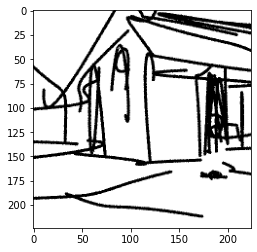

1
time: 46.45306444168091


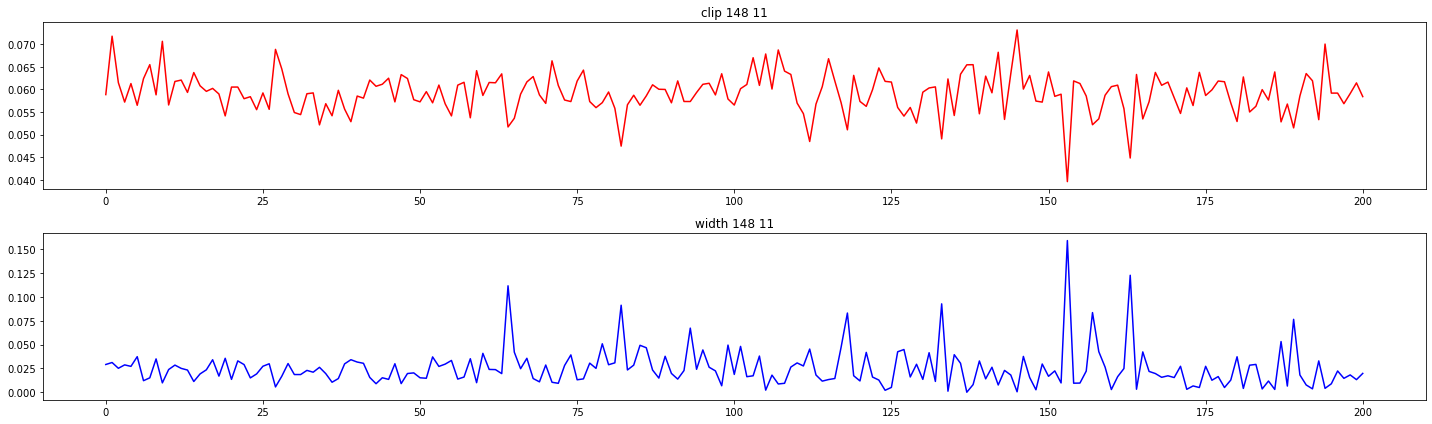

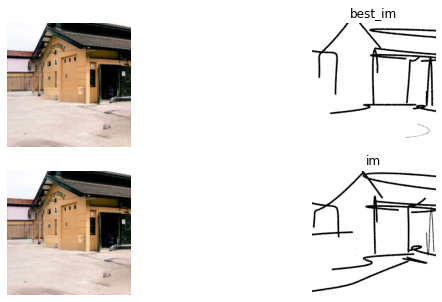

In [23]:
# tests

random.seed(0)
np.random.seed(0)
# os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(0)

im_name = "semi-complex_mask"
path_to_svgs = "/home/vinker/dev/background_project/experiements/mlp_19_06"
layers = [8]
layer_loss = 8
# weights = np.array([4]) 
weights = np.array([1])

canvas_size=224
num_strokes=32
num_cp=4
num_iter=201
print_int=1
widths = torch.ones(num_strokes) * 1.5
# train_mlp="points_width"
train_mlp="points_width"

run_simp(layers, path_to_svgs, im_name, layer_loss, weights)
    

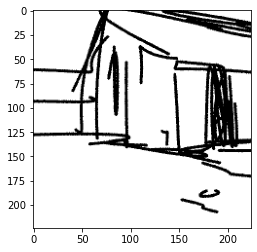

1
time: 42.049368381500244


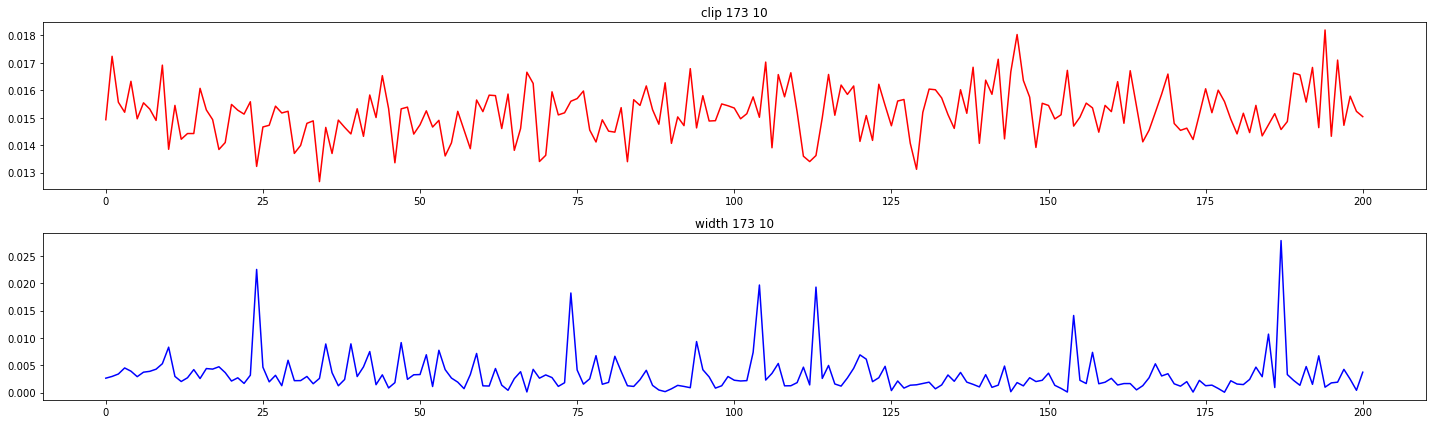

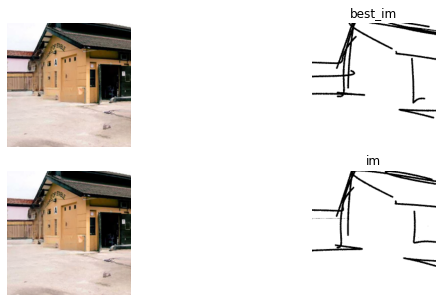

In [27]:
# tests
target_ = "/home/vinker/dev/input_images/background_sketching/semi-complex_mask.png"
random.seed(0)
np.random.seed(0)
# os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(0)

im_name = "semi-complex_mask"
path_to_svgs = "/home/vinker/dev/background_project/experiements/mlp_19_06"
layers = [4]
layer_loss = 4
# weights = np.array([4]) 
weights = np.array([1])

canvas_size=224
num_strokes=32
num_cp=4
num_iter=201
print_int=1
widths = torch.ones(num_strokes) * 1.5
# train_mlp="points_width"
train_mlp="points_width"

run_simp(layers, path_to_svgs, im_name, layer_loss, weights,target_)

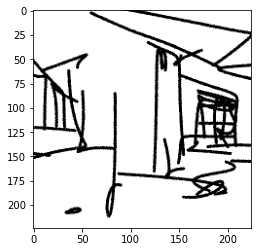

1
time: 58.79055070877075


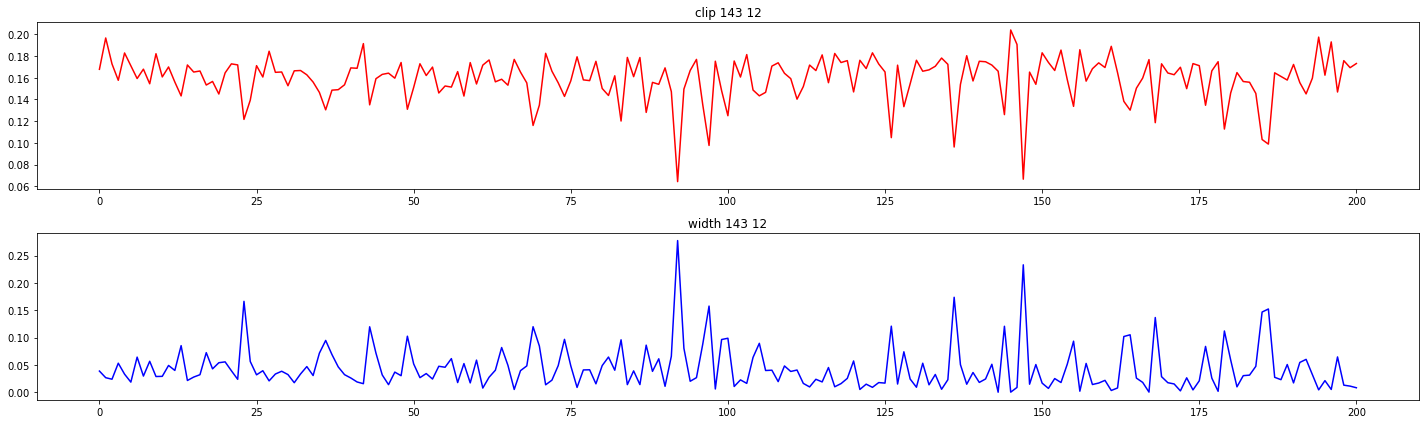

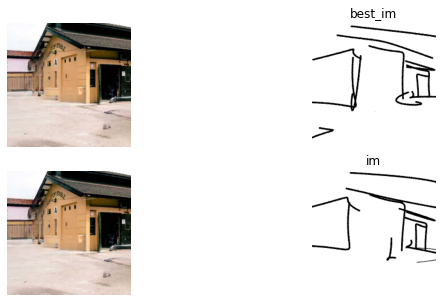

In [28]:
# tests
target_ = "/home/vinker/dev/input_images/background_sketching/semi-complex_mask.png"
random.seed(0)
np.random.seed(0)
# os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(0)

im_name = "semi-complex_mask"
path_to_svgs = "/home/vinker/dev/background_project/experiements/mlp_19_06"
layers = [11]
layer_loss = 11
# weights = np.array([4]) 
weights = np.array([1])

canvas_size=224
num_strokes=32
num_cp=4
num_iter=201
print_int=1
widths = torch.ones(num_strokes) * 1.5
# train_mlp="points_width"
train_mlp="points_width"

run_simp(layers, path_to_svgs, im_name, layer_loss, weights,target_)

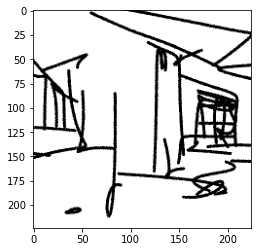

1
time: 46.79204726219177


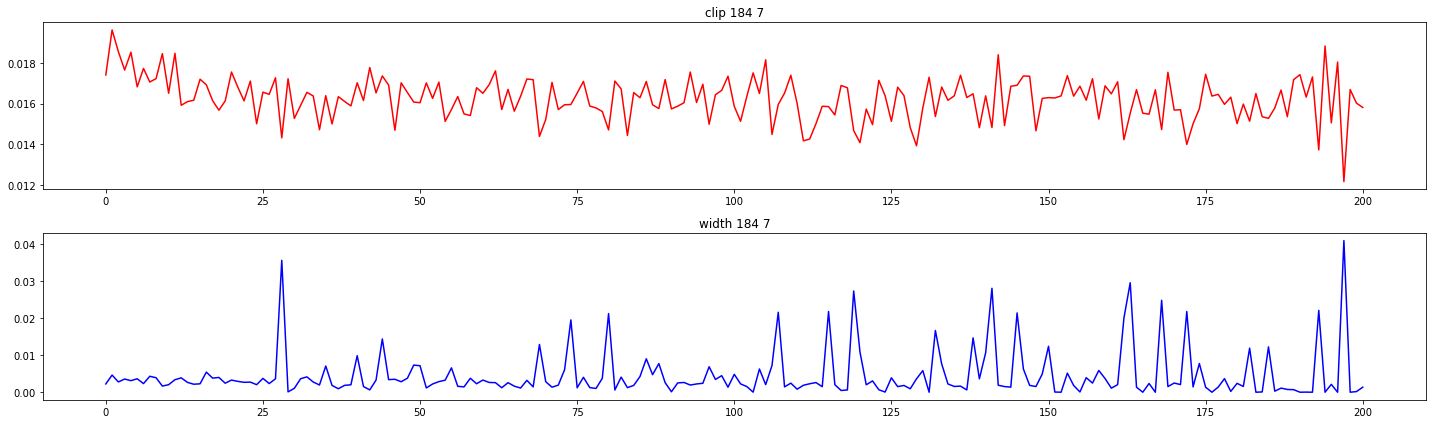

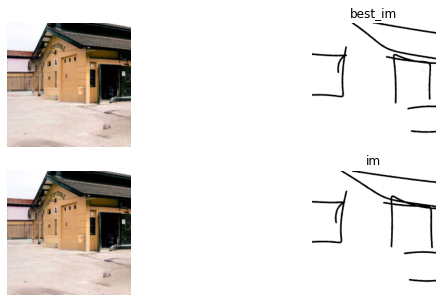

In [29]:
# tests
target_ = "/home/vinker/dev/input_images/background_sketching/semi-complex_mask.png"
random.seed(0)
np.random.seed(0)
# os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(0)

im_name = "semi-complex_mask"
path_to_svgs = "/home/vinker/dev/background_project/experiements/mlp_19_06"
layers = [11]
layer_loss = 4
# weights = np.array([4]) 
weights = np.array([1])

canvas_size=224
num_strokes=32
num_cp=4
num_iter=201
print_int=1
widths = torch.ones(num_strokes) * 1.5
# train_mlp="points_width"
train_mlp="points_width"

run_simp(layers, path_to_svgs, im_name, layer_loss, weights,target_)

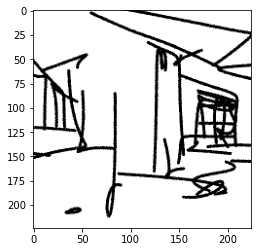

1
time: 51.98158359527588


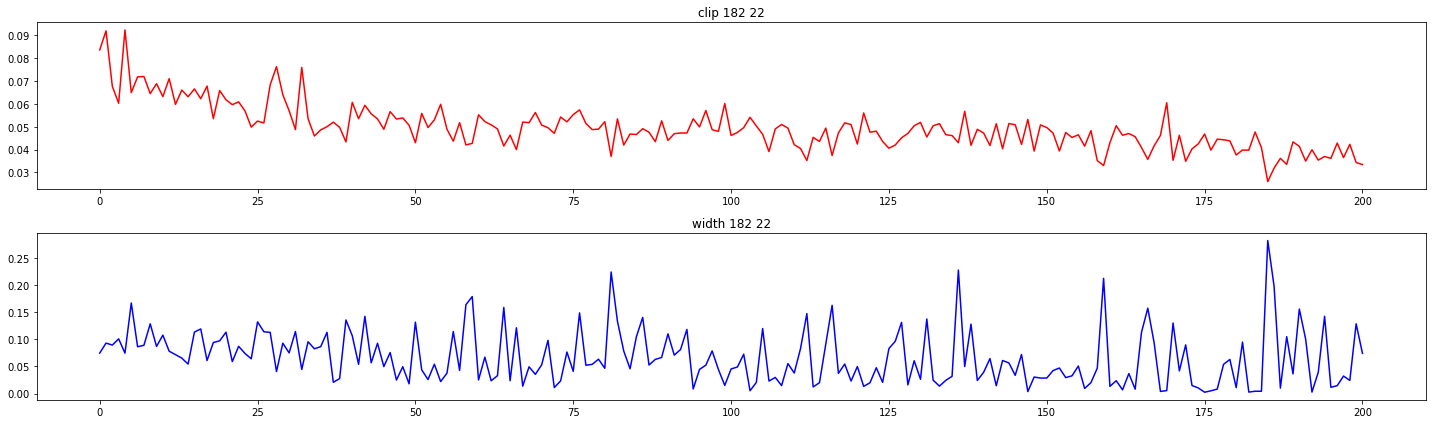

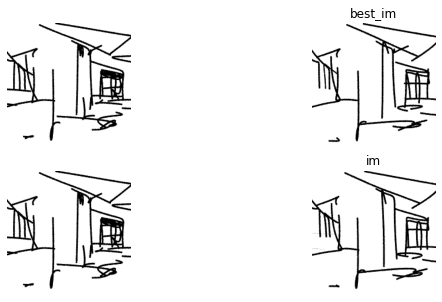

In [30]:
target_ = f"images/house_layer11.png"


random.seed(0)
np.random.seed(0)
# os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(0)

im_name = "semi-complex_mask"
path_to_svgs = "/home/vinker/dev/background_project/experiements/mlp_19_06"
layers = [11]
layer_loss = 11
# weights = np.array([4]) 
weights = np.array([1])

canvas_size=224
num_strokes=32
num_cp=4
num_iter=201
print_int=1
widths = torch.ones(num_strokes) * 1.5
# train_mlp="points_width"
train_mlp="points_width"

run_simp(layers, path_to_svgs, im_name, layer_loss, weights, target_)

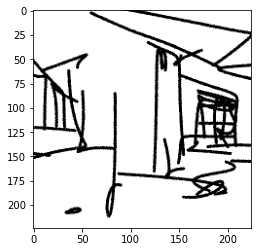

1
time: 43.497782945632935


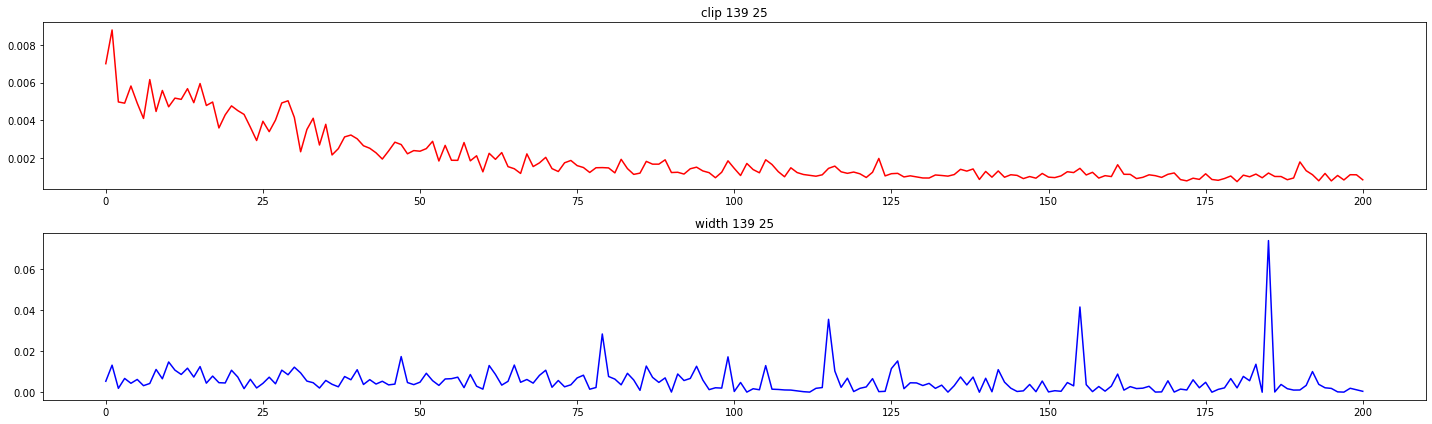

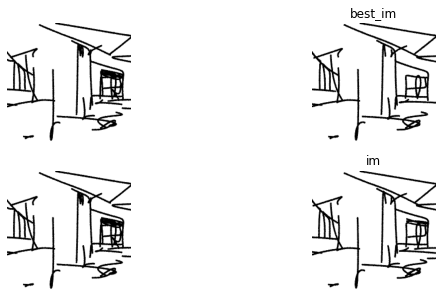

In [31]:
target_ = f"images/house_layer11.png"


random.seed(0)
np.random.seed(0)
# os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(0)

im_name = "semi-complex_mask"
path_to_svgs = "/home/vinker/dev/background_project/experiements/mlp_19_06"
layers = [11]
layer_loss = 4
# weights = np.array([4]) 
weights = np.array([1])

canvas_size=224
num_strokes=32
num_cp=4
num_iter=201
print_int=1
widths = torch.ones(num_strokes) * 1.5
# train_mlp="points_width"
train_mlp="points_width"

run_simp(layers, path_to_svgs, im_name, layer_loss, weights, target_)

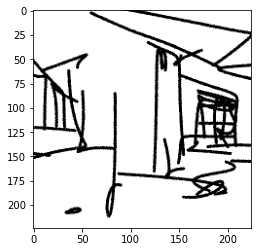

2
time: 44.29920482635498


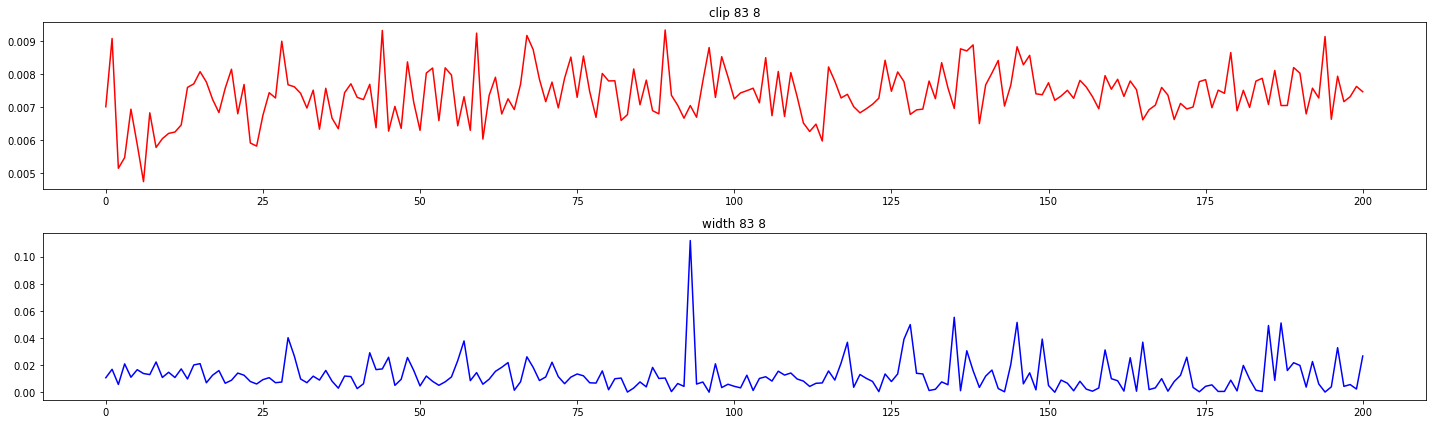

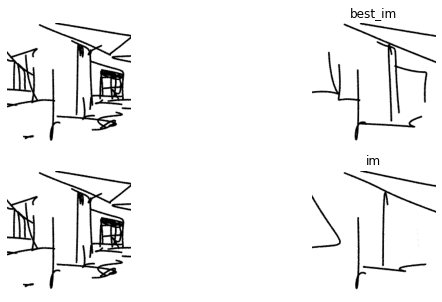

In [33]:
target_ = f"images/house_layer11.png"


random.seed(0)
np.random.seed(0)
# os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(0)

im_name = "semi-complex_mask"
path_to_svgs = "/home/vinker/dev/background_project/experiements/mlp_19_06"
layers = [11]
layer_loss = 4
# weights = np.array([4]) 
weights = np.array([2])

canvas_size=224
num_strokes=32
num_cp=4
num_iter=201
print_int=1
widths = torch.ones(num_strokes) * 1.5
# train_mlp="points_width"
train_mlp="points_width"

run_simp(layers, path_to_svgs, im_name, layer_loss, weights, target_)

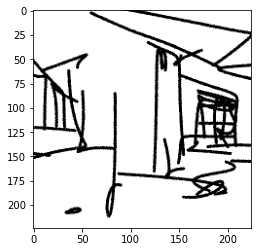

2
time: 45.716864585876465


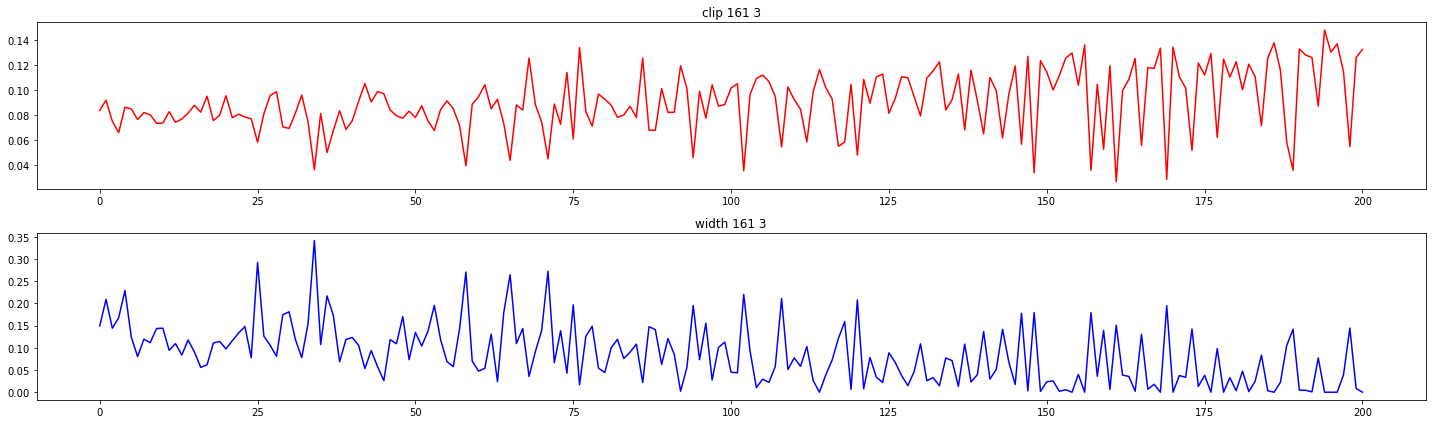

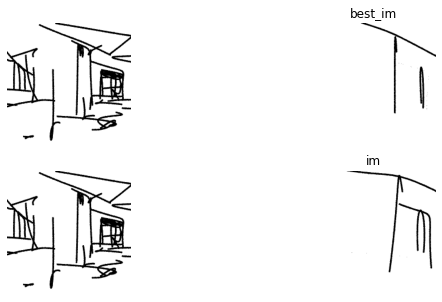

In [34]:
target_ = f"images/house_layer11.png"


random.seed(0)
np.random.seed(0)
# os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(0)

im_name = "semi-complex_mask"
path_to_svgs = "/home/vinker/dev/background_project/experiements/mlp_19_06"
layers = [11]
layer_loss = 11
# weights = np.array([4]) 
weights = np.array([2])

canvas_size=224
num_strokes=32
num_cp=4
num_iter=201
print_int=1
widths = torch.ones(num_strokes) * 1.5
# train_mlp="points_width"
train_mlp="points_width"

run_simp(layers, path_to_svgs, im_name, layer_loss, weights, target_)

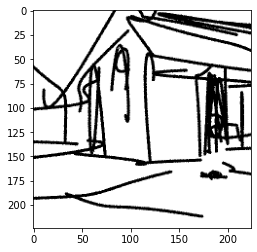

0.1


KeyboardInterrupt: 

<Figure size 1440x432 with 0 Axes>

In [25]:
# tests
target_ = f"images/house_layer8.png"
random.seed(0)
np.random.seed(0)
# os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(0)

im_name = "semi-complex_mask"
path_to_svgs = "/home/vinker/dev/background_project/experiements/mlp_19_06"
layers = [8]
layer_loss = 8
# weights = np.array([4]) 
weights = np.array([0.1, 1])

canvas_size=224
num_strokes=32
num_cp=4
num_iter=201
print_int=1
widths = torch.ones(num_strokes) * 1.5
# train_mlp="points_width"
train_mlp="points_width"

run_simp(layers, path_to_svgs, im_name, layer_loss, weights, target_)



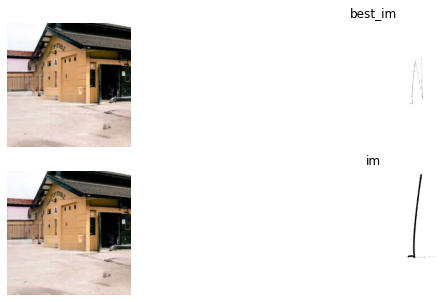

In [62]:
fig_loss = plt.figure(figsize=(10,5))
plt.subplot(2,len(results) + 1,1)
plt.imshow(target[0].permute(1,2,0).detach().cpu().numpy())
plt.axis("off")
plt.subplot(2,len(results) + 1,len(results) + 2)
plt.imshow(target[0].permute(1,2,0).detach().cpu().numpy())
plt.axis("off")
for i, res in enumerate(results):
    plt.subplot(2,len(results) + 1,i + 2)
    plt.imshow(res.detach().cpu().numpy())
    plt.axis("off")
    plt.title("best_im")
    plt.subplot(2,len(results) + 1,len(results) + i + 3)
    plt.imshow(results_f[i].detach().cpu().numpy())
    plt.axis("off")
    plt.title("im")
plt.show()
plt.close()

In [137]:
class MLP(nn.Module):
    def __init__(self, num_strokes, num_cp):
        super().__init__()
        outdim = 1000
        # num_strokes = 32
        self.layers_points = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_strokes * num_cp * 2, outdim),
            nn.SELU(inplace=True),
            nn.Linear(outdim, outdim),
            nn.SELU(inplace=True),
            # nn.ReLU(),
            # nn.Linear(1000, 1000),
            # nn.ReLU(),
            nn.Linear(outdim, num_strokes * num_cp * 2),
            # nn.Tanh()
        )
        
        # self.layers_width = nn.Sequential(
        #     nn.Linear(num_strokes, num_strokes),
        #     nn.SELU(inplace=True),
        #     nn.Linear(num_strokes, num_strokes),
        #     nn.SELU(inplace=True),
        #     nn.Linear(num_strokes, num_strokes),
        #     nn.Sigmoid()
        # )


    def forward(self, x, widths=None):
        '''Forward pass'''
        deltas = self.layers_points(x)
        # print(deltas.shape)
        # print(x.flatten().shape)
        # if widths is not None:
        #     return x.flatten() + 0.1 * deltas, self.layers_width(widths)
        return x.flatten() + 0.1 * deltas

mlp_clipasso_32s_easy-background-crop_seed0


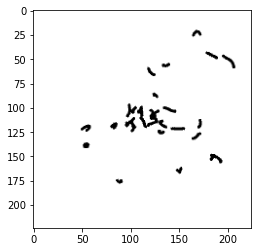

0.0001
time: 81.10435318946838
0.001
time: 81.43419146537781
0.01
time: 80.7241485118866


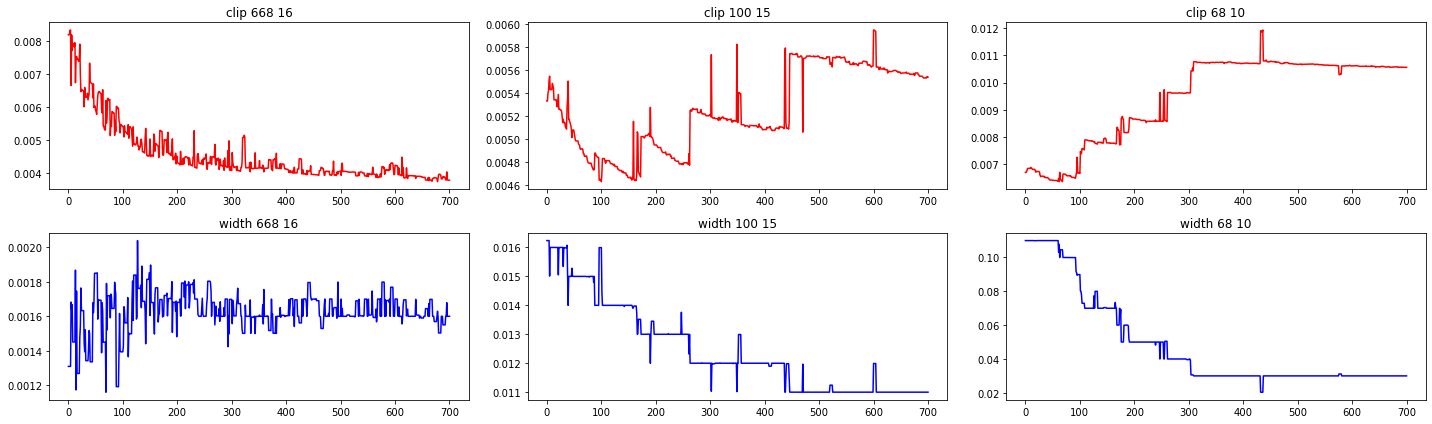

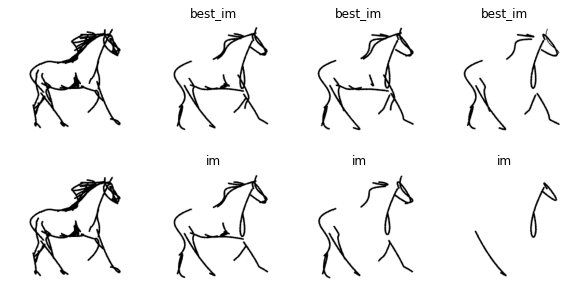

In [151]:
 # tests

random.seed(0)
np.random.seed(0)
# os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(0)

im_name = "semi-complex_mask"
path_to_svgs = "/home/vinker/dev/background_project/experiements/mlp_19_06"
layers = [4]
# weights = np.array([4]) 
# weights = np.array([0.0001, 0.001])
# weights = np.array([31, 24, 16, 8, 4]) 
# weights = np.array([0.0005])#, 0.001, 0.01]) 
weights = np.array([0.0001, 0.001, 0.01]) 

canvas_size=224
num_strokes=32
num_cp=4
num_iter=701
print_int=1
widths = torch.ones(num_strokes) * 1.5
train_mlp="points_width"

all_arr = []
for layer in layers:
    path_res = f"{path_to_svgs}/mlp_clipasso_32s_easy-background-crop/"
    svg_filename = get_svg_file(path_res)
    path_svg = f"{path_res}/{svg_filename}"
    
    # use the mlp, start from init0
    best_svg_folder = svg_filename[:-9]
    print(best_svg_folder)
    mlp_path = f"{path_res}/{best_svg_folder}/points_mlp.pt"
    svg_init_path = f"{path_res}/{best_svg_folder}/svg_logs/svg_iter0.svg"
    # return
    
    points_vars = get_initial_points(svg_init_path, device=device) # list of tensors
    points_vars = torch.stack(points_vars).unsqueeze(0).to(device)
    points_vars = points_vars / canvas_size
    points_vars = 2 * points_vars - 1
    
    target_ = f"images/horse_easy.png"
    target, mask = get_target(target_, device, image_scale=224)
    
    clip_conv_layer_weights=[0,0,0,0,0,0,0,0,0,0,0,0]
    clip_conv_layer_weights[4] = 1
    loss_clip = CLIPmaskLoss(clip_conv_layer_weights, mask)
    
    # mlp = MLP(num_strokes=num_strokes, num_cp=num_cp).to(device)
    # checkpoint = torch.load(mlp_path)
    # mlp.load_state_dict(checkpoint)
    
#     with torch.no_grad():
#         points_vars_ = mlp(points_vars, None)    
#     img_ = render_points(points_vars_, widths, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224)
#     plt.imshow(img_.cpu().detach().numpy())
#     plt.show()
    
#     if "points" not in train_mlp:
#         points_vars = points_vars_
    
    mlp_width = MLPWidth(num_strokes=num_strokes, num_cp=num_cp).to(device)
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    # mlp_width.apply(init_weights)
    
    # optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
    optimizer_width = torch.optim.Adam(mlp_width.parameters(), lr=1e-4)

    results = []
    results_f = []
    
    fig_loss = plt.figure(figsize=(20,6))
    for i, w in enumerate(weights):
        mlp = MLP(num_strokes=num_strokes, num_cp=num_cp).to(device)
        checkpoint = torch.load(mlp_path)
        mlp.load_state_dict(checkpoint['model_state_dict'])
        with torch.no_grad():
            points_vars_ = mlp(points_vars, None)    
        # img_ = render_points(points_vars_, widths, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224)
        # plt.imshow(img_.cpu().detach().numpy())
        # plt.show()

        if "points" not in train_mlp:
            points_vars = points_vars_
        print(w)
        optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start = time.time()
        im, best_im, losses_clip, losses_width, best_iter, best_num_strokes = optimize_through_net(target, points_vars, mlp, optimizer, 
                                                                                                   mlp_width, optimizer_width, loss_clip, 
                                                                                                   device, width_weight=w, canvas_size=224, 
                                                                                                   num_strokes=num_strokes, num_cp=4, 
                                                                                                   only_width=True, num_iter=num_iter, 
                                                                                                   print_int=print_int, width_loss="l1", train_mlp=train_mlp)
        
        plt.subplot(2,len(weights),i + 1)
        plt.plot(range(num_iter), losses_clip, color='r')
        plt.title(f"clip {best_iter} {int(best_num_strokes)}")
        
        plt.subplot(2,len(weights),len(weights) + i + 1)
        plt.plot(range(num_iter), losses_width, color='b')
        plt.title(f"width {best_iter} {int(best_num_strokes)}")
        results.append(best_im)
        results_f.append(im)
        print("time:", time.time() - start)
    del mlp
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    all_arr.append(results)
    # plt.figure(figsize=(20,10))
    plt.figure(figsize=(10,5))
    plt.subplot(2,len(results) + 1,1)
    plt.imshow(target[0].permute(1,2,0).detach().cpu().numpy())
    plt.axis("off")
    plt.subplot(2,len(results) + 1,len(results) + 2)
    plt.imshow(target[0].permute(1,2,0).detach().cpu().numpy())
    plt.axis("off")
    for i, res in enumerate(results):
        plt.subplot(2,len(results) + 1,i + 2)
        plt.imshow(res.detach().cpu().numpy())
        plt.axis("off")
        plt.title("best_im")
        plt.subplot(2,len(results) + 1,len(results) + i + 3)
        plt.imshow(results_f[i].detach().cpu().numpy())
        plt.axis("off")
        plt.title("im")
    plt.show()
    plt.close()

Cos_mlp_ViT_l4_32s_semi-complex_mask_seed0


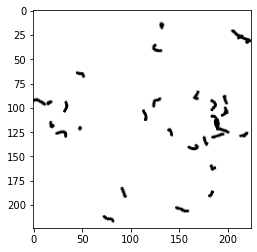

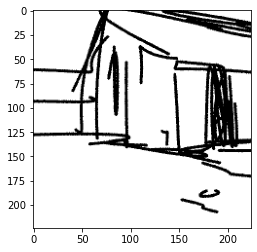

31
time: 96.77017283439636
24
time: 99.26093125343323
16
time: 99.82559084892273
8
time: 99.8211178779602


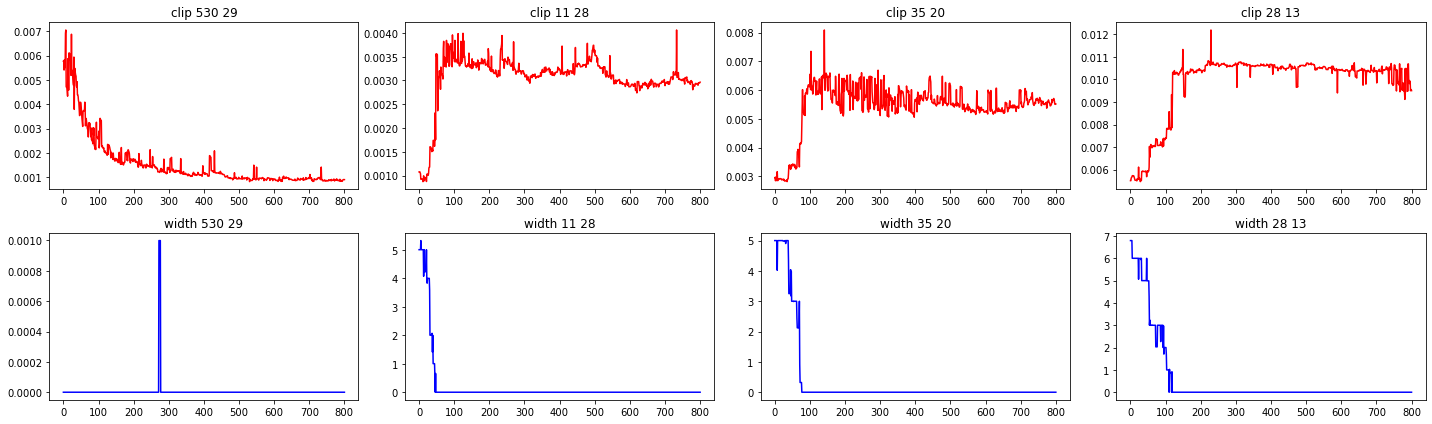

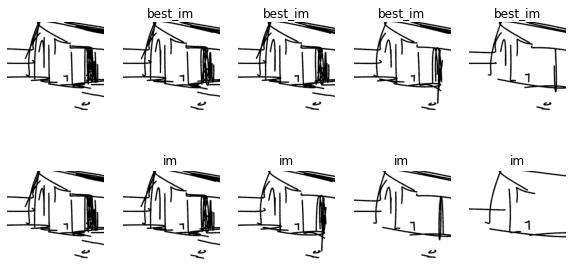

In [135]:
# tests

random.seed(0)
np.random.seed(0)
# os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(0)

im_name = "semi-complex_mask"
# path_to_svgs = "/home/vinker/dev/background_project/experiements/mlp_19_06"


path_to_svgs = "/home/vinker/dev/background_project/experiements/mlp_19_06"
layers = [4]
# weights = np.array([4]) 
# weights = np.array([0.0001, 0.001])
weights = np.array([31, 24, 16, 8]) 
# weights = np.array([0.0001, 0.0004, 0.0008, 0.001]) 

canvas_size=224
num_strokes=32
num_cp=4
num_iter=801
print_int=400
widths = torch.ones(num_strokes) * 1.5
train_mlp="points_width"

all_arr = []
for layer in layers:
    # print("hh")
    # path_res = f"{path_to_svgs}/mlp_clipasso_32s_easy-background-crop/"
    path_res = f"{path_to_svgs}/Cos_mlp_ViT_l{layer}_32s_{im_name}/"
    
    svg_filename = get_svg_file(path_res)
    path_svg = f"{path_res}/{svg_filename}"
    
    # use the mlp, start from init0
    best_svg_folder = svg_filename[:-9]
    print(best_svg_folder)
    mlp_path = f"{path_res}/{best_svg_folder}/mlp.pth"
    svg_init_path = f"{path_res}/{best_svg_folder}/svg_logs/svg_iter0.svg"
    # return
    
    points_vars = get_initial_points(svg_init_path, device=device) # list of tensors
    points_vars = torch.stack(points_vars).unsqueeze(0).to(device)
    points_vars = points_vars / canvas_size
    points_vars = 2 * points_vars - 1
    
    # target_ = f"images/horse_easy.png"
    target_ = f"images/house_layer{layer}.png"
    target, mask = get_target(target_, device, image_scale=224)
    
    clip_conv_layer_weights=[0,0,0,0,0,0,0,0,0,0,0,0]
    clip_conv_layer_weights[4] = 1
    loss_clip = CLIPmaskLoss(clip_conv_layer_weights, mask)
    
    mlp = MLP(num_strokes=num_strokes, num_cp=num_cp).to(device)
    checkpoint = torch.load(mlp_path)
    mlp.load_state_dict(checkpoint)
    
    with torch.no_grad():
        points_vars_ = mlp(points_vars, None)    
    img_ = render_points(points_vars_, widths, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224)
    plt.imshow(img_.cpu().detach().numpy())
    plt.show()
    
    if "points" not in train_mlp:
        points_vars = points_vars_
    
    mlp_width = MLPWidth(num_strokes=num_strokes, num_cp=num_cp).to(device)
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    # mlp_width.apply(init_weights)
    
    optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
    optimizer_width = torch.optim.Adam(mlp_width.parameters(), lr=1e-4)

    results = []
    results_f = []
    
    fig_loss = plt.figure(figsize=(20,6))
    for i, w in enumerate(weights):
        print(w)
        start = time.time()
        im, best_im, losses_clip, losses_width, best_iter, best_num_strokes = optimize_through_net(target, points_vars, mlp, optimizer, 
                                                                                                   mlp_width, optimizer_width, loss_clip, 
                                                                                                   device, width_weight=w, canvas_size=224, 
                                                                                                   num_strokes=num_strokes, num_cp=4, 
                                                                                                   only_width=True, num_iter=num_iter, 
                                                                                                   print_int=print_int, width_loss="l1_hinge", train_mlp=train_mlp)
        
        plt.subplot(2,len(weights),i + 1)
        plt.plot(range(num_iter), losses_clip, color='r')
        plt.title(f"clip {best_iter} {int(best_num_strokes)}")
        
        plt.subplot(2,len(weights),len(weights) + i + 1)
        plt.plot(range(num_iter), losses_width, color='b')
        plt.title(f"width {best_iter} {int(best_num_strokes)}")
        results.append(best_im)
        results_f.append(im)
        print("time:", time.time() - start)
    del mlp
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    all_arr.append(results)
    # plt.figure(figsize=(20,10))
    plt.figure(figsize=(10,5))
    plt.subplot(2,len(results) + 1,1)
    plt.imshow(target[0].permute(1,2,0).detach().cpu().numpy())
    plt.axis("off")
    plt.subplot(2,len(results) + 1,len(results) + 2)
    plt.imshow(target[0].permute(1,2,0).detach().cpu().numpy())
    plt.axis("off")
    for i, res in enumerate(results):
        plt.subplot(2,len(results) + 1,i + 2)
        plt.imshow(res.detach().cpu().numpy())
        plt.axis("off")
        plt.title("best_im")
        plt.subplot(2,len(results) + 1,len(results) + i + 3)
        plt.imshow(results_f[i].detach().cpu().numpy())
        plt.axis("off")
        plt.title("im")
    plt.show()
    plt.close()